In [1]:
import numpy as np
from xgboost import XGBRanker
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import psycopg2
from gensim.models.doc2vec import Doc2Vec
from gensim.utils import simple_preprocess
import tensorflow as tf
import tensorflow.keras.backend as K
from faiss import read_index
from psycopg2.extras import execute_values
import pickle
import pandas as pd
from operator import itemgetter
from utils.utils import get_q_answers


plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

2024-06-28 11:52:06.764380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Create dataset

In [4]:
connection = psycopg2.connect(
    user="postgres",
    password="postgres",
    host="127.0.0.1",
    port="54320",
    database="stack_overflow",
)

In [11]:
question_embeddings_model = Doc2Vec.load("python.doc")
question_transformer_model = tf.keras.models.load_model(
    "../../scripts/text_model/question_transformer_model"
)
index = read_index("../../scripts/text_model/users_imp.index")

In [12]:
with open("../../scripts/text_model/user_embeddings.pickle", "rb") as f:
    user_embedding, user_encoder = pickle.load(f)

In [13]:
MIN_ANSWERS = 3
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            f"""select p.id, p.title, p.body_text
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join posts_19 a on a.parent_id=p.id
        join tags t on pt.tag_id=t.id
        where p.body_text is not null
        and p.creation_date >= '2022-01-01'
        and t.tag_name = 'python'
        group by p.id
        HAVING count(*) > {MIN_ANSWERS}
        limit 30000"""
        )
        posts = cursor.fetchall()

In [14]:
posts_vectors = []
posts_ids = []
for p_id, title, body in posts:
    posts_ids.append(p_id)
    post_text = body
    if title is not None:
        post_text = title + "\n\n" + body
    posts_vectors.append(
        question_embeddings_model.infer_vector(simple_preprocess(post_text))
    )

In [15]:
posts_vectors = np.array(posts_vectors)
posts_vectors.shape

(3973, 50)

In [16]:
questions_transformed = question_transformer_model.predict(posts_vectors)
questions_transformed.shape

125/125 [==============================] - 0s 731us/step


(3973, 10)

In [17]:
qid2emb = {pid: emb for pid, emb in zip(posts_ids, questions_transformed)}

In [18]:
distances, similar_questions = index.search(questions_transformed, 10000)
features_df = pd.DataFrame(
    list(zip(posts_ids, similar_questions)), columns=["q_id", "u_id"]
).explode("u_id")
features_df["u_id"] = features_df["u_id"].astype(int)

In [19]:
features_df

,q_id,u_id
0,70547027,4962195
0,70547027,10659910
0,70547027,5405298
0,70547027,5535114
0,70547027,5660284
...,...,...
3972,74681417,4082726
3972,74681417,12043163
3972,74681417,1353861
3972,74681417,6331369


In [20]:
batch_size = 1000000

results = []
with connection:
    for batch_idx in range(len(features_df) // batch_size):
        with connection.cursor() as cursor:
            execute_values(
                cursor,
                """select q_id, u_id, q_a.score
                                    FROM (VALUES %s) AS base_questions (q_id, u_id)
                                    JOIN posts_19 q_a ON q_a.parent_id = q_id
                                    WHERE q_a.owner_user_id=u_id""",
                features_df[batch_idx * batch_size : (batch_idx + 1) * batch_size][
                    ["q_id", "u_id"]
                ].values.tolist(),
                page_size=batch_size,
            )
            results.extend(cursor.fetchall())
dataset = pd.DataFrame(results, columns=["q_id", "u_id", "score"])

In [21]:
dataset.sort_values(by=["q_id"], inplace=True)
print(len(dataset))
dataset.head()

5605


,q_id,u_id,score
124,70547027,2988730,2
144,70547027,5014455,2
71,70547027,2988730,0
145,70547281,786593,0
33,70547426,1192111,0


In [22]:
full_dataset = features_df.merge(dataset, on=["q_id", "u_id"], how="left")

In [23]:
full_dataset["feats"] = np.concatenate(
    (
        user_embedding[user_encoder.transform(full_dataset["u_id"])],
        np.array(itemgetter(*full_dataset["q_id"])(qid2emb)),
    ),
    axis=1,
).tolist()

In [24]:
scored_dataset = full_dataset[~full_dataset["score"].isna()]
eval_feats = np.array(scored_dataset["feats"].values.tolist())
eval_scores = scored_dataset["score"]
eval_q_ids = scored_dataset["q_id"]

# Load LTR

In [25]:
ranker = XGBRanker()
ranker.load_model("xgboost_ranker")

In [26]:
predicted_scores = ranker.predict(eval_feats)

grouped_predicted_scores = []
grouped_eval_scores = []

last_qid = eval_q_ids.values[0]
last_predicted_scores = []
last_eval_scores = []
for pscore, escore, q_id in zip(predicted_scores, eval_scores, eval_q_ids):
    if q_id == last_qid:
        last_predicted_scores.append(pscore)
        last_eval_scores.append(escore)
    else:
        grouped_predicted_scores.append(last_predicted_scores)
        grouped_eval_scores.append(last_eval_scores)
        last_predicted_scores = [pscore]
        last_eval_scores = [escore]
        last_qid = q_id

grouped_predicted_scores.append(last_predicted_scores)
grouped_eval_scores.append(last_eval_scores)

In [27]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

group_ncdg = []

for p_scores, e_scores in zip(grouped_predicted_scores, grouped_eval_scores):
    if len(p_scores) > 1:
        group_ncdg.append(ndcg_score([p_scores], [e_scores]))

group_ncdg = np.array(group_ncdg)
group_ncdg.mean(), group_ncdg.std()

(1.0, 1.879287516223711e-16)

# Evaluate recall

In [28]:
full_dataset["pscore"] = ranker.predict(np.array(full_dataset["feats"].values.tolist()))

In [29]:
full_dataset["is_answer"] = (~full_dataset["score"].isna()).astype(int)
full_dataset["is_answer"].sum()

5605

In [30]:
full_dataset = full_dataset.sort_values(by=["q_id", "pscore"], ascending=False)

In [31]:
full_dataset.head(10)

,q_id,u_id,score,feats,pscore,is_answer
39720061,74681417,6657231,NaN,"[-0.32010993361473083, -0.32003816962242126, 0...",0.159008,0
39720062,74681417,11476836,NaN,"[-0.3203243017196655, -0.32027503848075867, 0....",0.159008,0
39720063,74681417,803194,NaN,"[-0.3199814260005951, -0.32052743434906006, 0....",0.159008,0
39720064,74681417,13965517,NaN,"[-0.32054489850997925, -0.31964626908302307, 0...",0.159008,0
39720065,74681417,10239789,NaN,"[-0.3206108808517456, -0.3199508488178253, 0.3...",0.159008,0
39720066,74681417,9311137,NaN,"[-0.32043126225471497, -0.32004314661026, 0.31...",0.159008,0
39720067,74681417,1491895,NaN,"[-0.32051166892051697, -0.32023823261260986, 0...",0.159008,0
39720068,74681417,15897202,NaN,"[-0.32069385051727295, -0.32037508487701416, 0...",0.159008,0
39720069,74681417,118903,NaN,"[-0.3199869394302368, -0.32062122225761414, 0....",0.159008,0
39720070,74681417,12216324,NaN,"[-0.32068586349487305, -0.32030683755874634, 0...",0.159008,0


In [32]:
total_questions = len(full_dataset["q_id"].unique())

In [33]:
top_k = [20, 100, 1000, 4000, 7000, 10000]
mean_retrieved_documents = []
for k in top_k:
    mean_retrieved_documents.append(
        full_dataset.groupby("q_id")
        .apply(lambda x: x.head(k)["is_answer"].sum())
        .median()
    )

In [34]:
mean_retrieved_documents

[0.0, 0.0, 0.0, 1.0, 1.0, 1.0]

In [88]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """select q_a.parent_id, count(*) as answers
                            FROM posts_19 q_a
                            where q_a.parent_id in %s
                            group by q_a.parent_id""",
            (tuple(posts_ids),),
        )
        q_answers = cursor.fetchall()

In [89]:
q_answers = {q_id: answers for q_id, answers in q_answers}

In [95]:
top_k = list(range(1, 10000, 200))

In [96]:
mean_recall = []
for k in top_k:
    mean_recall.append(
        (
            full_dataset.groupby("q_id")[["is_answer", "q_id"]].apply(
                lambda x: x.head(k)["is_answer"].sum() / q_answers[x["q_id"].iloc[0]]
            )
        ).mean()
    )

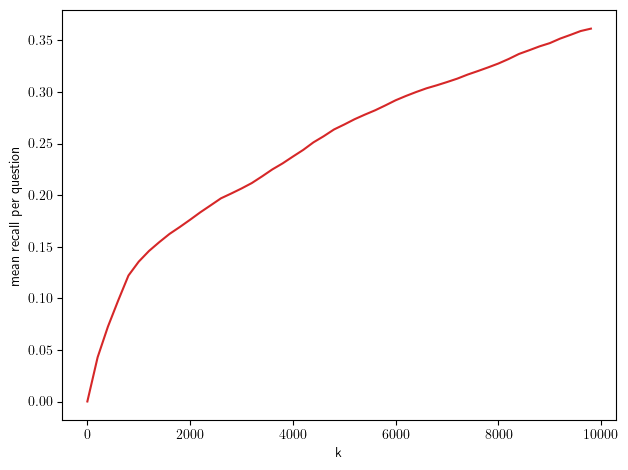

In [98]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean recall per question")
ax1.plot(top_k, mean_recall, color=color)

fig.savefig("xgboostrank_recall.pdf")
fig.tight_layout()
plt.show()

In [99]:
list(zip(top_k, mean_recall))

[(1, 6.292474200855777e-05),
 (201, 0.042889004750318614),
 (401, 0.07252229969320328),
 (601, 0.09787759294429318),
 (801, 0.12209864275054307),
 (1001, 0.1355484658530216),
 (1201, 0.1458980877052863),
 (1401, 0.1544396719705051),
 (1601, 0.16244111133992833),
 (1801, 0.16912731464078054),
 (2001, 0.17614402265799195),
 (2201, 0.18340395795719228),
 (2401, 0.19010464393676074),
 (2601, 0.19688643291714017),
 (2801, 0.20154765809183126),
 (3001, 0.20641634423411417),
 (3201, 0.2116724579221433),
 (3401, 0.21813602749293662),
 (3601, 0.22490193546699963),
 (3801, 0.23073475940956434),
 (4001, 0.23733446616029044),
 (4201, 0.2437605805275073),
 (4401, 0.25111408573527877),
 (4601, 0.2570635792319659),
 (4801, 0.2635837810705669),
 (5001, 0.26840531451656546),
 (5201, 0.27350881073508815),
 (5401, 0.27796058641137933),
 (5601, 0.2821528724372923),
 (5801, 0.2869193717041691),
 (6001, 0.29188922775633064),
 (6201, 0.2960600394655265),
 (6401, 0.29990803726016413),
 (6601, 0.30347087610490

# get dev country with uid and idx

In [36]:
users = pd.read_csv("users_dev_country.csv")
users.head()

,user_id,country,value,developed_country
0,22545,new zealand,0.937,1
1,22550,india,0.633,0
2,22554,india,0.633,0
3,22562,germany,0.942,1
4,22564,ireland,0.945,1


In [37]:
full_dataset = full_dataset.join(
    users[["user_id", "developed_country"]].set_index("user_id"), on="u_id"
)
full_dataset.head()

,q_id,u_id,score,feats,pscore,is_answer,developed_country
39720061,74681417,6657231,NaN,"[-0.32010993361473083, -0.32003816962242126, 0...",0.159008,0,0.0
39720062,74681417,11476836,NaN,"[-0.3203243017196655, -0.32027503848075867, 0....",0.159008,0,NaN
39720063,74681417,803194,NaN,"[-0.3199814260005951, -0.32052743434906006, 0....",0.159008,0,NaN
39720064,74681417,13965517,NaN,"[-0.32054489850997925, -0.31964626908302307, 0...",0.159008,0,1.0
39720065,74681417,10239789,NaN,"[-0.3206108808517456, -0.3199508488178253, 0.3...",0.159008,0,1.0


In [38]:
full_dataset["idx"] = full_dataset.groupby("q_id")["q_id"].cumcount()
full_dataset.head()

,q_id,u_id,score,feats,pscore,is_answer,developed_country,idx
39720061,74681417,6657231,NaN,"[-0.32010993361473083, -0.32003816962242126, 0...",0.159008,0,0.0,0
39720062,74681417,11476836,NaN,"[-0.3203243017196655, -0.32027503848075867, 0....",0.159008,0,NaN,1
39720063,74681417,803194,NaN,"[-0.3199814260005951, -0.32052743434906006, 0....",0.159008,0,NaN,2
39720064,74681417,13965517,NaN,"[-0.32054489850997925, -0.31964626908302307, 0...",0.159008,0,1.0,3
39720065,74681417,10239789,NaN,"[-0.3206108808517456, -0.3199508488178253, 0.3...",0.159008,0,1.0,4


In [39]:
full_dataset.to_csv("xgboost_ltr_dataset.csv",index=False)

In [40]:
q_answers_dev_country, q_answers_no_dev_country = get_q_answers(connection, tuple(posts_ids))
len(q_answers_dev_country), len(q_answers_no_dev_country)

(2788, 2806)

In [49]:
top_k = range(1, 101, 20)

dev_dataset = full_dataset[full_dataset["developed_country"] == 1]
no_dev_dataset = full_dataset[full_dataset["developed_country"] == 0]

dev_mean_recall = []
no_dev_mean_recall = []
for k in top_k:    
    dev_recall = (dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: (
                x[x["idx"] <= k]["is_answer"].sum()
            )
        )
        .dropna())
    dev_mean_recall.append(dev_recall.sum())    
    
    no_dev_recall = (no_dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: (
                x[x["idx"] <= k]["is_answer"].sum()
            )
        )
        .dropna()
    )
    no_dev_mean_recall.append(no_dev_recall.sum())

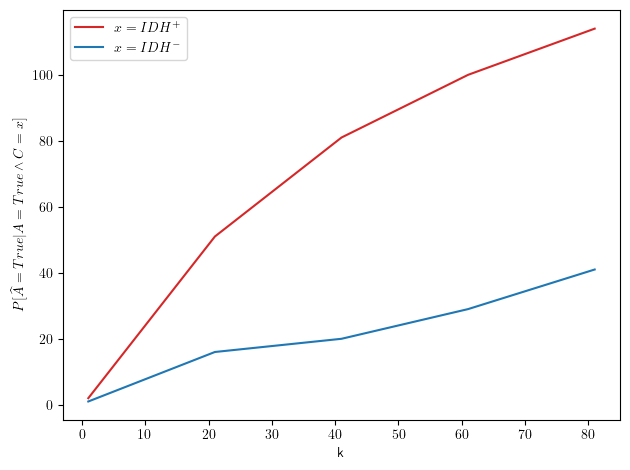

In [50]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("$P[\widehat{A}=True|A=True \land C=x]$")
ax1.plot(top_k, dev_mean_recall, color=color, label="$x=IDH^+$")
ax1.plot(top_k, no_dev_mean_recall, color="tab:blue", label="$x=IDH^-$")
ax1.legend(loc="upper left")

fig.tight_layout()

In [44]:
top_k = range(1, 101, 20)

dev_dataset = full_dataset[full_dataset["developed_country"] == 1]
no_dev_dataset = full_dataset[full_dataset["developed_country"] == 0]

dev_mean_recall = []
no_dev_mean_recall = []
for k in top_k:    
    dev_recall = (dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: (
                x[x["idx"] <= k]["is_answer"].sum()
                / q_answers_dev_country[x["q_id"].iloc[0]]
                if x["q_id"].iloc[0] in q_answers_dev_country
                else np.NaN
            )
        )
        .dropna())
    dev_mean_recall.append(dev_recall.mean())    
    
    no_dev_recall = (no_dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: (
                x[x["idx"] <= k]["is_answer"].sum()
                / q_answers_no_dev_country[x["q_id"].iloc[0]]
                if x["q_id"].iloc[0] in q_answers_no_dev_country
                else np.NaN
            )
        )
        .dropna()
    )
    no_dev_mean_recall.append(no_dev_recall.mean())

In [45]:
len(full_dataset), len(dev_dataset), len(no_dev_dataset)

(39730061, 11753494, 13931587)

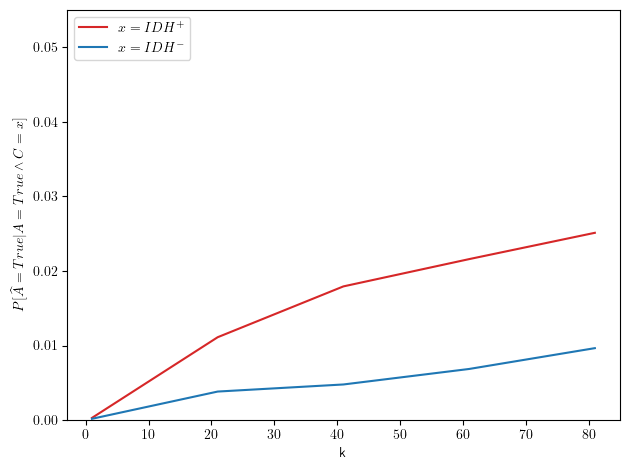

In [46]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("$P[\widehat{A}=True|A=True \land C=x]$")
ax1.plot(top_k, dev_mean_recall, color=color, label="$x=IDH^+$")
ax1.plot(top_k, no_dev_mean_recall, color="tab:blue", label="$x=IDH^-$")
ax1.set_ylim(0, 0.055)
ax1.legend(loc="upper left")

fig.tight_layout()
fig.savefig("recall_mean_before.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


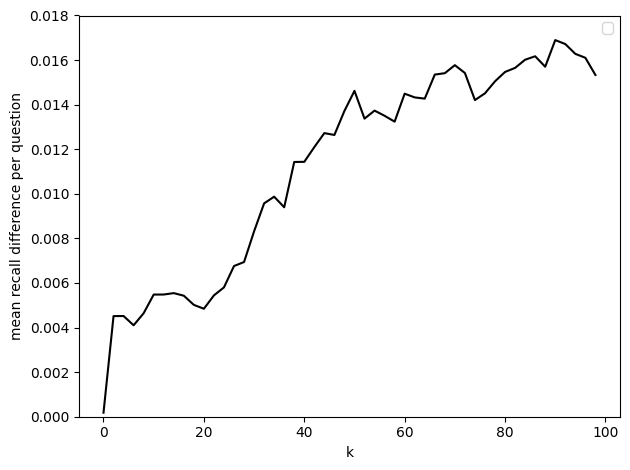

In [39]:
fig, ax1 = plt.subplots()

dev_mean_recall_difference = [np.absolute(k_dev_mean_recall - k_no_dev_mean_recall)
                             for k_dev_mean_recall, k_no_dev_mean_recall
                             in zip(dev_mean_recall, no_dev_mean_recall)]
color = "black"
ax1.set_xlabel("k")
ax1.set_ylabel("mean recall difference per question")
ax1.plot(top_k, dev_mean_recall_difference, color=color)
ax1.set_ylim(0, 0.018)

fig.savefig("recall_difference_before.pdf")
fig.tight_layout()
ax1.legend()

In [27]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """SELECT q_a.parent_id, count(*) as answers
                FROM posts_19 q_a
                where q_a.parent_id in %s
                group by q_a.parent_id""",
            (tuple(posts_ids),),
        )
        q_answers_result = cursor.fetchall()
q_answers = {q_id: count_answers for q_id, count_answers in q_answers_result}

In [27]:
top_k = range(0, 101)

mean_recall = []
for k in top_k:    
    k_recall = (full_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: (
                x[x["idx"] <= k]["is_answer"].sum()
                / q_answers[x["q_id"].iloc[0]]
                if x["q_id"].iloc[0] in q_answers
                else np.NaN
            )
        )
        .dropna())
    mean_recall.append(k_recall.mean())



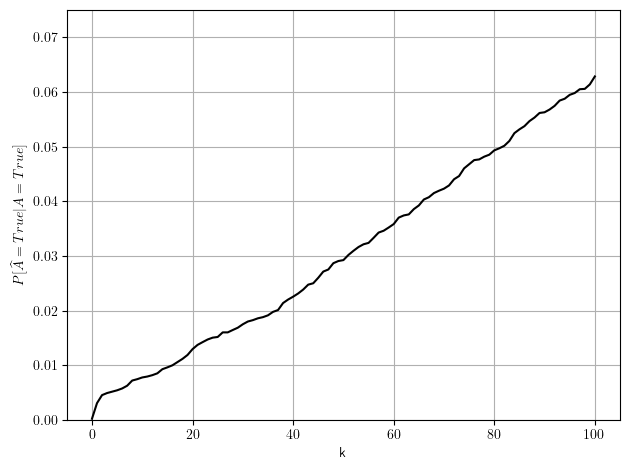

In [29]:
fig, ax1 = plt.subplots()

color = "black"
ax1.set_xlabel("k")
ax1.set_ylabel("$P[\widehat{A}=True|A=True]$")
ax1.plot(top_k, mean_recall, color=color)
ax1.set_ylim(0, 0.075)
ax1.grid()

fig.tight_layout()
fig.savefig("recall_mean_before_all.pdf")

In [100]:
mean_recall = []
for k in range(1, 100):
    mean_recall.append(
        (
            full_dataset.groupby("q_id")[["is_answer", "q_id"]].apply(
                lambda x: x.head(k)["is_answer"].sum() / q_answers[x["q_id"].iloc[0]]
            )
        ).mean()
    )

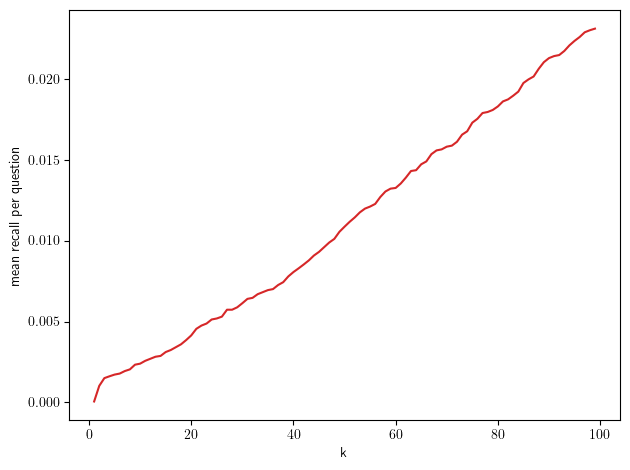

In [102]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean recall per question")
ax1.plot(list(range(1, 100)), mean_recall, color=color)

fig.tight_layout()
plt.show()

armar el end2end con los q nuevos, evaluar el recall, ncdg a p candidatos

In [43]:

# aramar el baseline con random

In [44]:
# median +iqr gapplot 

# Random candidates

In [ ]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(f"""
        select u.id, sum(a.score)
        from users u
            join posts_19 a on a.owner_user_id=u.id
            join posts_19 p on a.parent_id=p.id
            join posts_19_tags pt on pt.post_id=p.id
            join tags t on pt.tag_id=t.id
        where p.creation_date < '2022-01-01'
            and t.tag_name = 'python'
        group by u.id
        order by 2 desc
        limit 10000
        """)
        top_users = cursor.fetchall()



In [52]:

with open('posts_ids_top_users.pickle', 'wb') as f:
    pickle.dump((posts_ids, top_users), f)

In [3]:

with open('posts_ids_top_users.pickle', 'rb') as f:
    posts_ids, top_users = pickle.load(f)

In [4]:
len(posts_ids), len(top_users)

(3973, 10000)

In [20]:
# TODO:repeat every element instead
u_ids = np.repeat(np.array([uid for uid, scor in top_users]), len(posts_ids))

random_df = pd.DataFrame(list(zip(posts_ids * 10000, u_ids)), columns=["q_id", "u_id"])
random_df.head()

,q_id,u_id
0,70547027,100297
1,70547281,100297
2,70547426,100297
3,70549423,100297
4,70550513,100297


# Evaluate recall

In [21]:
results = []
batch_size = 1000000

with connection:
    for batch_idx in range(len(random_df) // batch_size):
        with connection.cursor() as cursor:
            execute_values(
                cursor,
                """select q_id, u_id, q_a.score
                        FROM (VALUES %s) AS base_questions (q_id, u_id)
                        JOIN posts_19 q_a ON q_a.parent_id = q_id
                        WHERE q_a.owner_user_id=u_id""",
                random_df[batch_idx * batch_size : (batch_idx + 1) * batch_size][
                    ["q_id", "u_id"]
                ].values.tolist(),
                page_size=batch_size,
            )
            results.extend(cursor.fetchall())
random_df_scores = pd.DataFrame(results, columns=["q_id", "u_id", "score"])

In [22]:
random_df_scores.head()

,q_id,u_id,score
0,71434012,16343464,1
1,71786720,1491895,3
2,72098906,16343464,3
3,72132786,7964527,2
4,72249268,7964527,5


In [23]:
random_df.head()

,q_id,u_id
0,70547027,100297
1,70547281,100297
2,70547426,100297
3,70549423,100297
4,70550513,100297


In [24]:
random_df2 = random_df.merge(random_df_scores, on=["q_id", "u_id"], how="left")

In [25]:
random_df2["is_answer"] = (~random_df2["score"].isna()).astype(int)
random_df2.head()

,q_id,u_id,score,is_answer
0,70547027,100297,NaN,0
1,70547281,100297,NaN,0
2,70547426,100297,NaN,0
3,70549423,100297,NaN,0
4,70550513,100297,NaN,0


In [54]:
top_k = list([1] + list(range(1275, 1281)) + list(range(1285, 1291)) + list(range(1295, 1301))
    + list(range(1380, 1386)) + list(range(1655, 1661)) + list(range(2555, 2561))
          + list(range(2575, 2581))+ [10000])

mean_recall_random = []
for k in top_k:
    mean_recall_random.append(
        (
            random_df2.groupby("q_id")[["is_answer", "q_id"]].apply(
                lambda x: x.head(k)["is_answer"].sum() / q_answers[x["q_id"].iloc[0]]
            )
        ).median()
    )

In [53]:
len(list([1] + list(range(1275, 1281)) + list(range(1285, 1291)) + list(range(1295, 1301))
    + list(range(1380, 1386)) + list(range(1655, 1661)) + list(range(2555, 2561))
          + list(range(2575, 2581))+ [10000]))

44

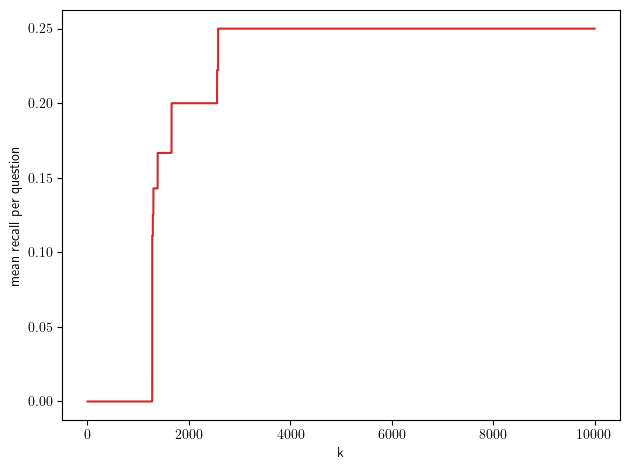

In [57]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean recall per question")
ax1.plot(top_k, mean_recall_random, color=color)

fig.tight_layout()
fig.savefig("baseline_recall.pdf")
plt.show()

In [56]:
list(zip(top_k, mean_recall_random))

[(1, 0.0),
 (1275, 0.0),
 (1276, 0.0),
 (1277, 0.1111111111111111),
 (1278, 0.1111111111111111),
 (1279, 0.1111111111111111),
 (1280, 0.1111111111111111),
 (1285, 0.1111111111111111),
 (1286, 0.1111111111111111),
 (1287, 0.1111111111111111),
 (1288, 0.1111111111111111),
 (1289, 0.125),
 (1290, 0.125),
 (1295, 0.125),
 (1296, 0.125),
 (1297, 0.125),
 (1298, 0.125),
 (1299, 0.125),
 (1300, 0.14285714285714285),
 (1380, 0.14285714285714285),
 (1381, 0.14285714285714285),
 (1382, 0.14285714285714285),
 (1383, 0.14285714285714285),
 (1384, 0.16666666666666666),
 (1385, 0.16666666666666666),
 (1655, 0.16666666666666666),
 (1656, 0.16666666666666666),
 (1657, 0.16666666666666666),
 (1658, 0.2),
 (1659, 0.2),
 (1660, 0.2),
 (2555, 0.2),
 (2556, 0.2222222222222222),
 (2557, 0.2222222222222222),
 (2558, 0.2222222222222222),
 (2559, 0.2222222222222222),
 (2560, 0.2222222222222222),
 (2575, 0.2222222222222222),
 (2576, 0.25),
 (2577, 0.25),
 (2578, 0.25),
 (2579, 0.25),
 (2580, 0.25),
 (10000, 0.2

In [ ]:
top_k = list(range(1, 10000))

def calculate_top_k_p_all(k):
    top_df = fair_dataset.groupby("q_id", group_keys=False)[
        ["developed_country", "is_answer", "q_id"]
    ].apply(lambda x: x.head(k))
    return top_df["is_answer"].mean()


with Pool(8) as p:
    p_is_answer_all = p.map(calculate_top_k_p_all, top_k)